Import Necessary Packages

In [76]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy
from statsmodels.stats import multitest

Read in Processed Metabolic Data

In [77]:
metabolism_data = pd.read_csv("../Data/Generated Data/processed_metabolite_data.csv")
list_of_cell_lines = metabolism_data.index
#metabolism_data = metabolism_data.set_index("Unnamed: 0")
meta_data = pd.read_csv("../Data/Generated Data/meta_data.csv")

Fit Principal Component Analysis

In [78]:
from sklearn.decomposition import PCA
model = PCA(n_components=10)            # 2. Instantiate the model with hyperparameters
model.fit(metabolism_data)                      # 3. Fit to data. Notice y is not specified!
X_2D = model.transform(metabolism_data)
explained_variance = model.explained_variance_ratio_

Plot Tissue of Origin vs. Principal Components

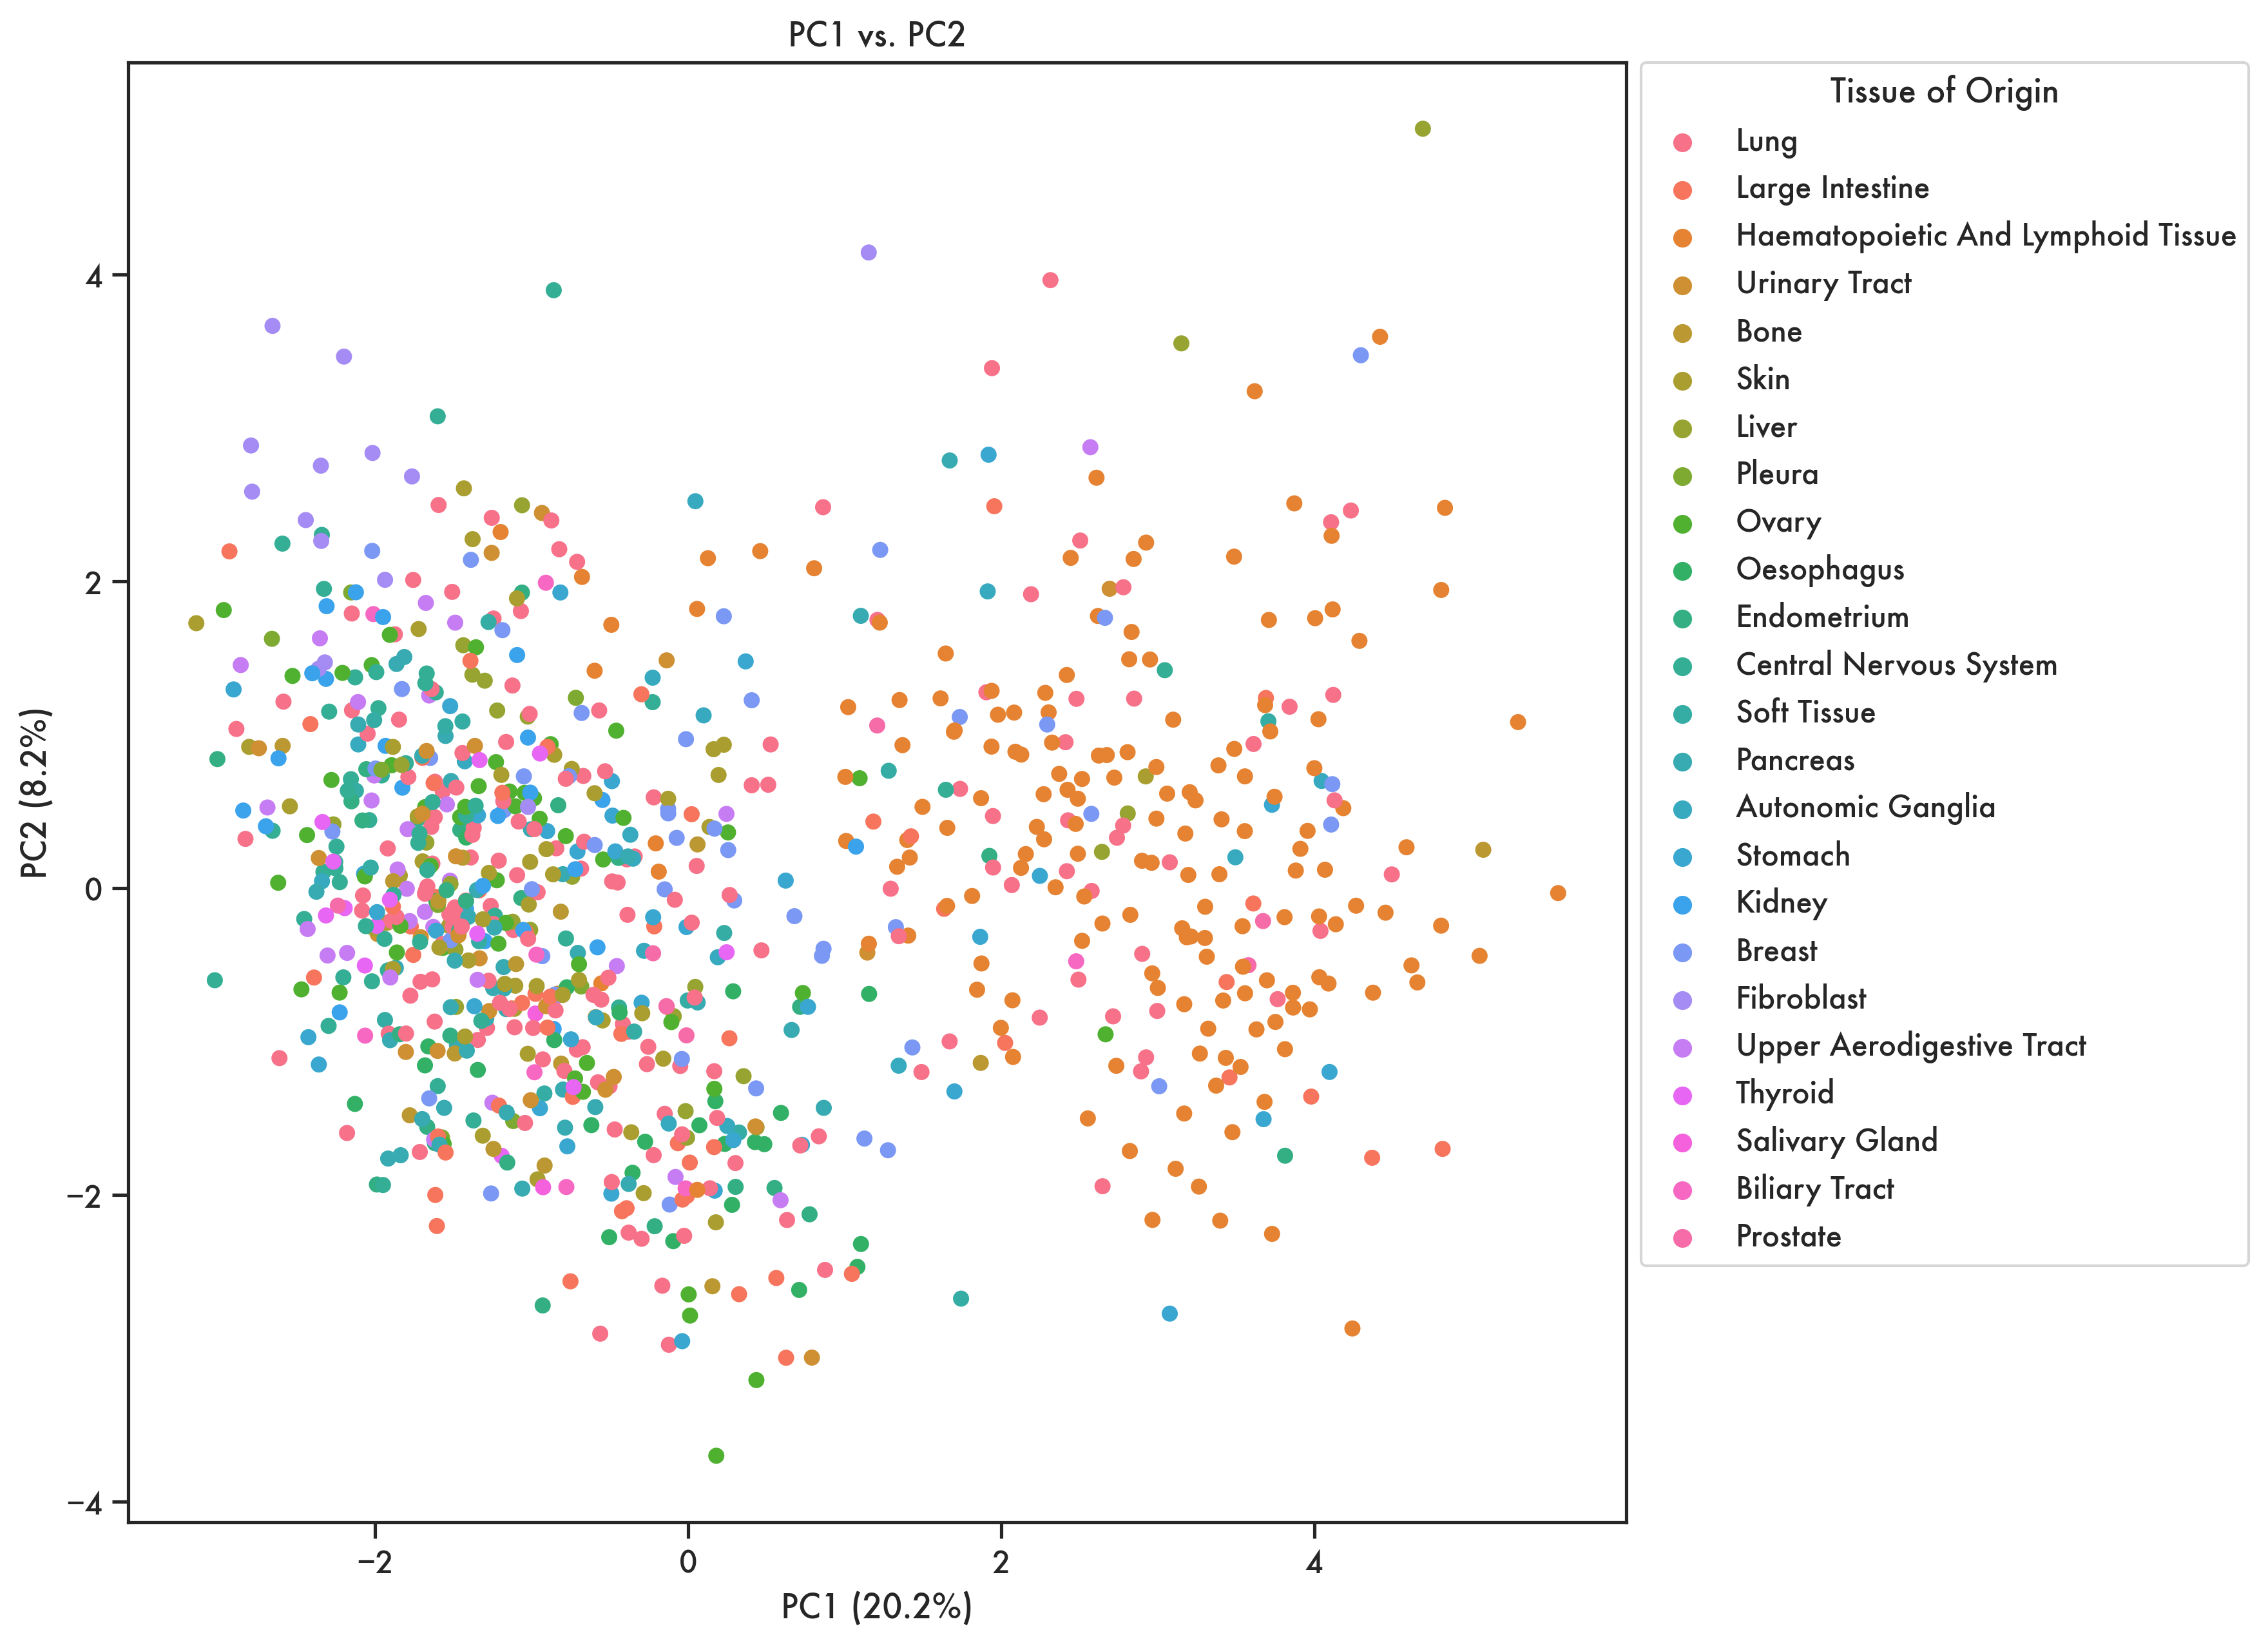

In [80]:
sns.set_theme(style = "ticks", rc={'figure.figsize':(10,10),"figure.dpi":300, 'savefig.dpi':300,"font.family":"Futura"})
for x in range(0,5):
    metabolism_data["PC"+ str(x+1)] = X_2D[:, x]
metabolism_data["Tissue of Origin"] = [" ".join((x.split("_")[1:])) for x in metabolism_data.index]
metabolism_data["Tissue of Origin"] = metabolism_data["Tissue of Origin"].str.title()
fig,axpca = plt.subplots()
scatter = sns.scatterplot(x = "PC1", y = "PC2", data=metabolism_data,hue = "Tissue of Origin",legend = "full", sizes= 1,linewidth=0)
axpca.set(xlabel='PC1 ({}%)'.format(round(explained_variance[0]*100, 1)), ylabel='PC2 ({}%)'.format(round(explained_variance[1]*100, 1)),title = "PC1 vs. PC2")
sns.move_legend(axpca,"upper left", bbox_to_anchor=(1, 1.01))

Calculate Extracellular Environment (Growth Medium) and Tissue of Origin ANOVA

In [82]:
meta_data = meta_data[metabolism_data.index].transpose()
metabolism_data = pd.concat([metabolism_data, meta_data[["Doubling.Time.Calculated.hrs", "mutRate", "Growth.Medium"]]], axis = 1)

ANOVA for Tissue of Origin

In [6]:
matrix = pd.DataFrame(columns = ["F statistic","p-value", "Covariate"])
for i in range(1,6):
    listOflist = []
    print(i)
    for tissue in metabolism_data["Tissue of Origin"].unique():
        listOflist.append(metabolism_data.loc[metabolism_data["Tissue of Origin"] == tissue]["PC%i" %i].values)
    matrix.loc["%i" %i] = (list(scipy.stats.f_oneway(*listOflist))+ ["Tissue of Origin"])
matrix["p-value (corrected)"] =  multitest.multipletests(pvals = matrix["p-value"], alpha = .05, method = "holm")[1]

1
2
3
4
5


ANOVA for Extracellular Environment (Growth Medium)

In [83]:
metabolism_data_sub = metabolism_data.dropna(subset = ["Growth.Medium"])
matrix = pd.DataFrame(columns = ["F statistic","p-value", "Covariate"])
for i in range(1,6):
    listOflist = []
    print(i)
    for media in metabolism_data_sub["Growth.Medium"].unique():
        listOflist.append(metabolism_data_sub.loc[metabolism_data_sub["Growth.Medium"] == media]["PC%i" %i].values)
    matrix.loc["%i" %i] = (list(scipy.stats.f_oneway(*listOflist))+ ["Growth Medium"])
matrix["p-value (corrected)"] =  multitest.multipletests(pvals = matrix["p-value"], alpha = .05, method = "holm")[1]

1
2
3
4
5


Plot Extracellular Environment along PC4 vs. PC5

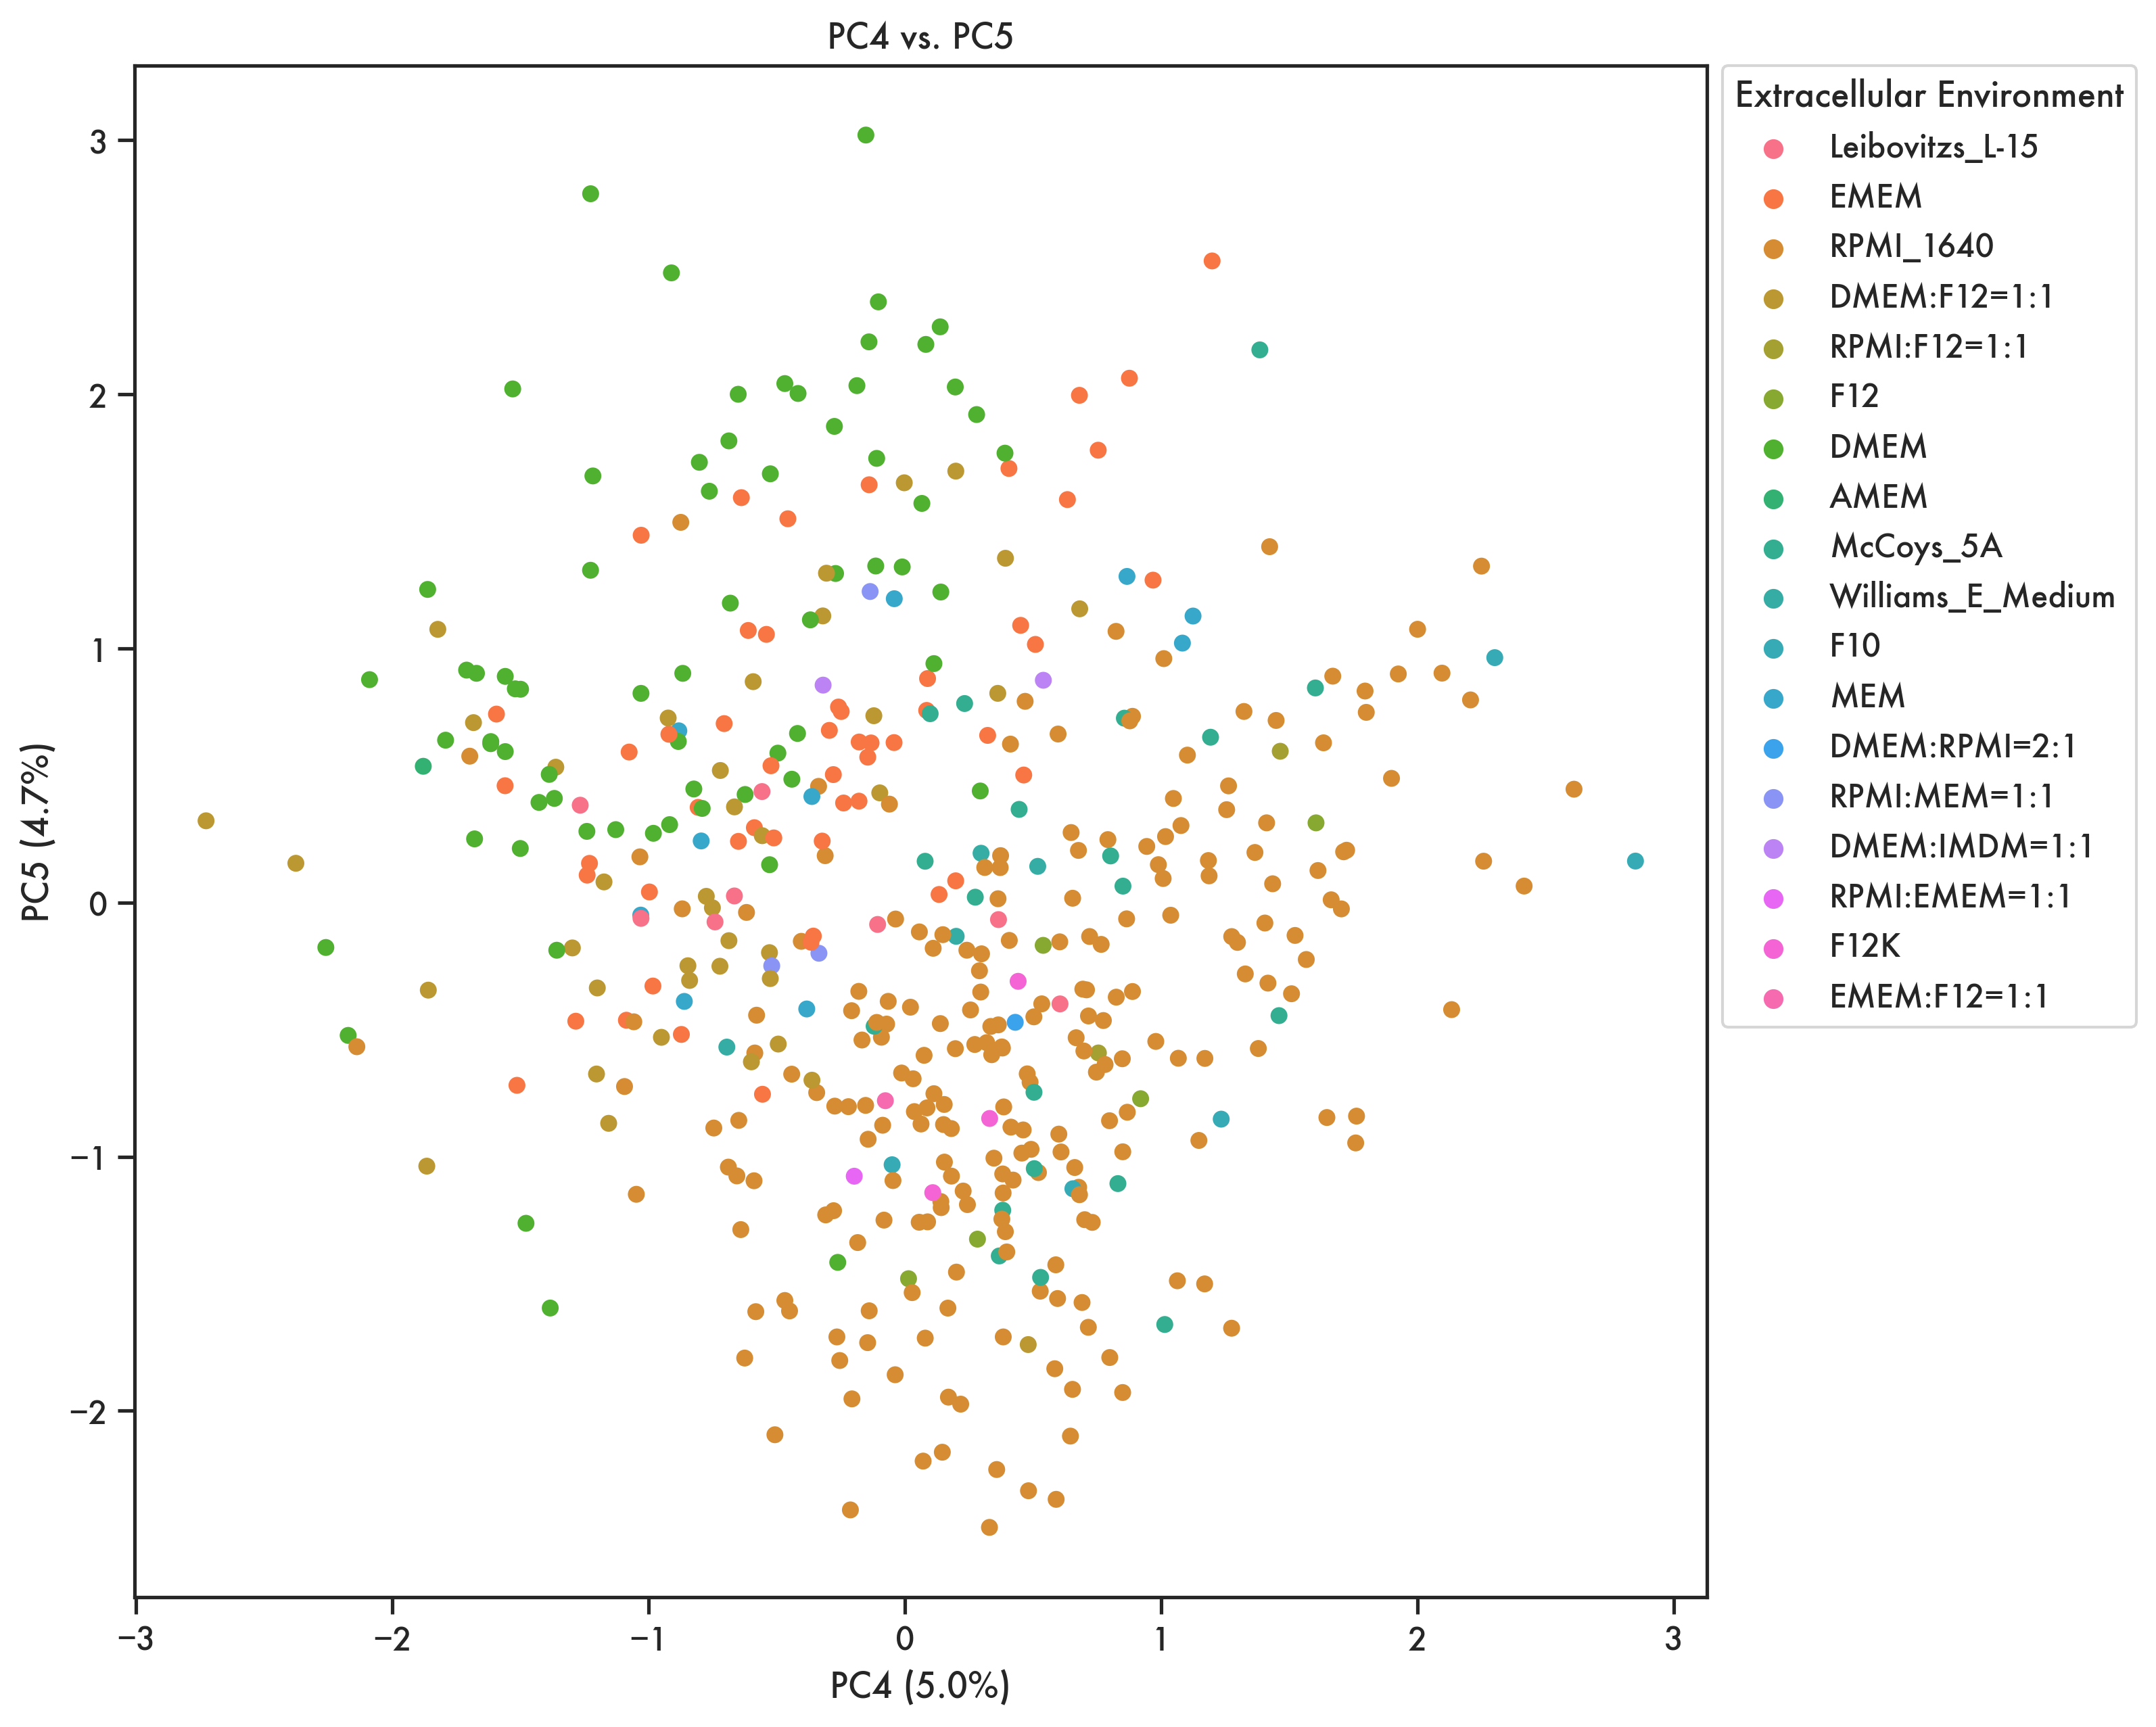

In [84]:
sns.set_theme(style = "ticks", rc={'figure.figsize':(10,10),"figure.dpi":300, 'savefig.dpi':300, 'font.family':"Futura"})
fig,axpca = plt.subplots()
metabolism_data_sub = metabolism_data.copy()
metabolism_data_sub.loc[:,"Extracellular Environment"] = metabolism_data_sub.loc[:,"Growth.Medium"]
scatter = sns.scatterplot(x = "PC4", y = "PC5", data=metabolism_data_sub,hue = "Extracellular Environment",legend = "full", sizes= 1,linewidth=0)
axpca.set(xlabel='PC4 ({}%)'.format(round(explained_variance[3]*100, 1)), ylabel='PC5 ({}%)'.format(round(explained_variance[4]*100, 1)),title= "PC4 vs. PC5")
sns.move_legend(axpca,"upper left", bbox_to_anchor=(1, 1.01))

Calculate Pearson and Spearman Correlation on Doubling Time

In [13]:
metabolism_data_sub = metabolism_data.dropna(subset = ["Doubling.Time.Calculated.hrs"])
from scipy.stats import pearsonr
for i in range(1,6):
        rho, p = pearsonr(metabolism_data_sub["PC%i" %i], metabolism_data_sub["Doubling.Time.Calculated.hrs"].astype(float))
        print(i)
        print(rho, p)


1
0.07720616267506543 0.07303241381380611
2
0.28228320788569045 2.37625148195708e-11
3
0.12632655730005585 0.0032763022604551787
4
-0.05022108884506203 0.2439932611355679
5
-0.12154001304091044 0.004679860552418574


In [14]:
# multiple hypothesis correction
from scipy.stats import spearmanr
matrix = pd.DataFrame(columns = ["R-value","p-value", "Covariate"])
for i in range(1,6):
        rho, p = spearmanr(metabolism_data_sub["PC%i" %i], metabolism_data_sub["Doubling.Time.Calculated.hrs"].astype(float))
        matrix.loc["%i"%i]= [rho,p,"Doubling Time"]
matrix["p-value (corrected)"] =  multitest.multipletests(pvals = matrix["p-value"], alpha = .05, method = "holm")[1]
matrix

R-value       p-value      Covariate  p-value (corrected)
1  0.035001  4.169552e-01  Doubling Time         4.169552e-01
2  0.373831  2.360315e-19  Doubling Time         1.180157e-18
3  0.140684  1.045641e-03  Doubling Time         3.136924e-03
4 -0.066024  1.254310e-01  Doubling Time         2.508620e-01
5 -0.168027  8.728178e-05  Doubling Time         3.491271e-04

Calculate Pearson and Spearman Correlation on Mutation Rate

In [15]:
metabolism_data_sub = metabolism_data.dropna(subset = ["mutRate"])
from scipy.stats import pearsonr
for i in range(1,6):
        rho, p = pearsonr(metabolism_data_sub["PC%i" %i], metabolism_data_sub["mutRate"].astype(float))
        print(i)
        print(rho, p)

1
0.020273470482158416 0.543122684384926
2
-0.13191973771938698 7.071348903559259e-05
3
0.07754005551979877 0.01985573258862792
4
-0.02443751716489403 0.46353929861876614
5
0.01891570944849955 0.5704666072039833


In [16]:
from scipy.stats import spearmanr
matrix = pd.DataFrame(columns = ["R-value","p-value", "Covariate"])
for i in range(1,6):
        rho, p = spearmanr(metabolism_data_sub["PC%i" %i], metabolism_data_sub["mutRate"].astype(float))
        print(rho, p)
        matrix.loc["%i"%i]= [rho,p,"mutRate"]
matrix["p-value (corrected)"] =  multitest.multipletests(pvals = matrix["p-value"], alpha = .05, method = "holm")[1]
matrix

-0.0017668553913968508 0.9577390934547916
-0.12840986832889698 0.00011007101623299365
0.06688493641541966 0.04461779916299476
0.0413692805111428 0.21450782744083055
-0.013237357085466861 0.6913469518101831


R-value   p-value Covariate  p-value (corrected)
1 -0.001767  0.957739   mutRate             1.000000
2 -0.128410  0.000110   mutRate             0.000550
3  0.066885  0.044618   mutRate             0.178471
4  0.041369  0.214508   mutRate             0.643523
5 -0.013237  0.691347   mutRate             1.000000

Plot mutation rate and growth rate on PC3 vs. PC4

/var/folders/jh/5fjcdzvn7csgsswjnkqx0c_00000gp/T/ipykernel_24314/1675621878.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metabolism_data_sub["Growth Rate (log2)"] = np.log2(metabolism_data_sub["Doubling Time"].astype(float))


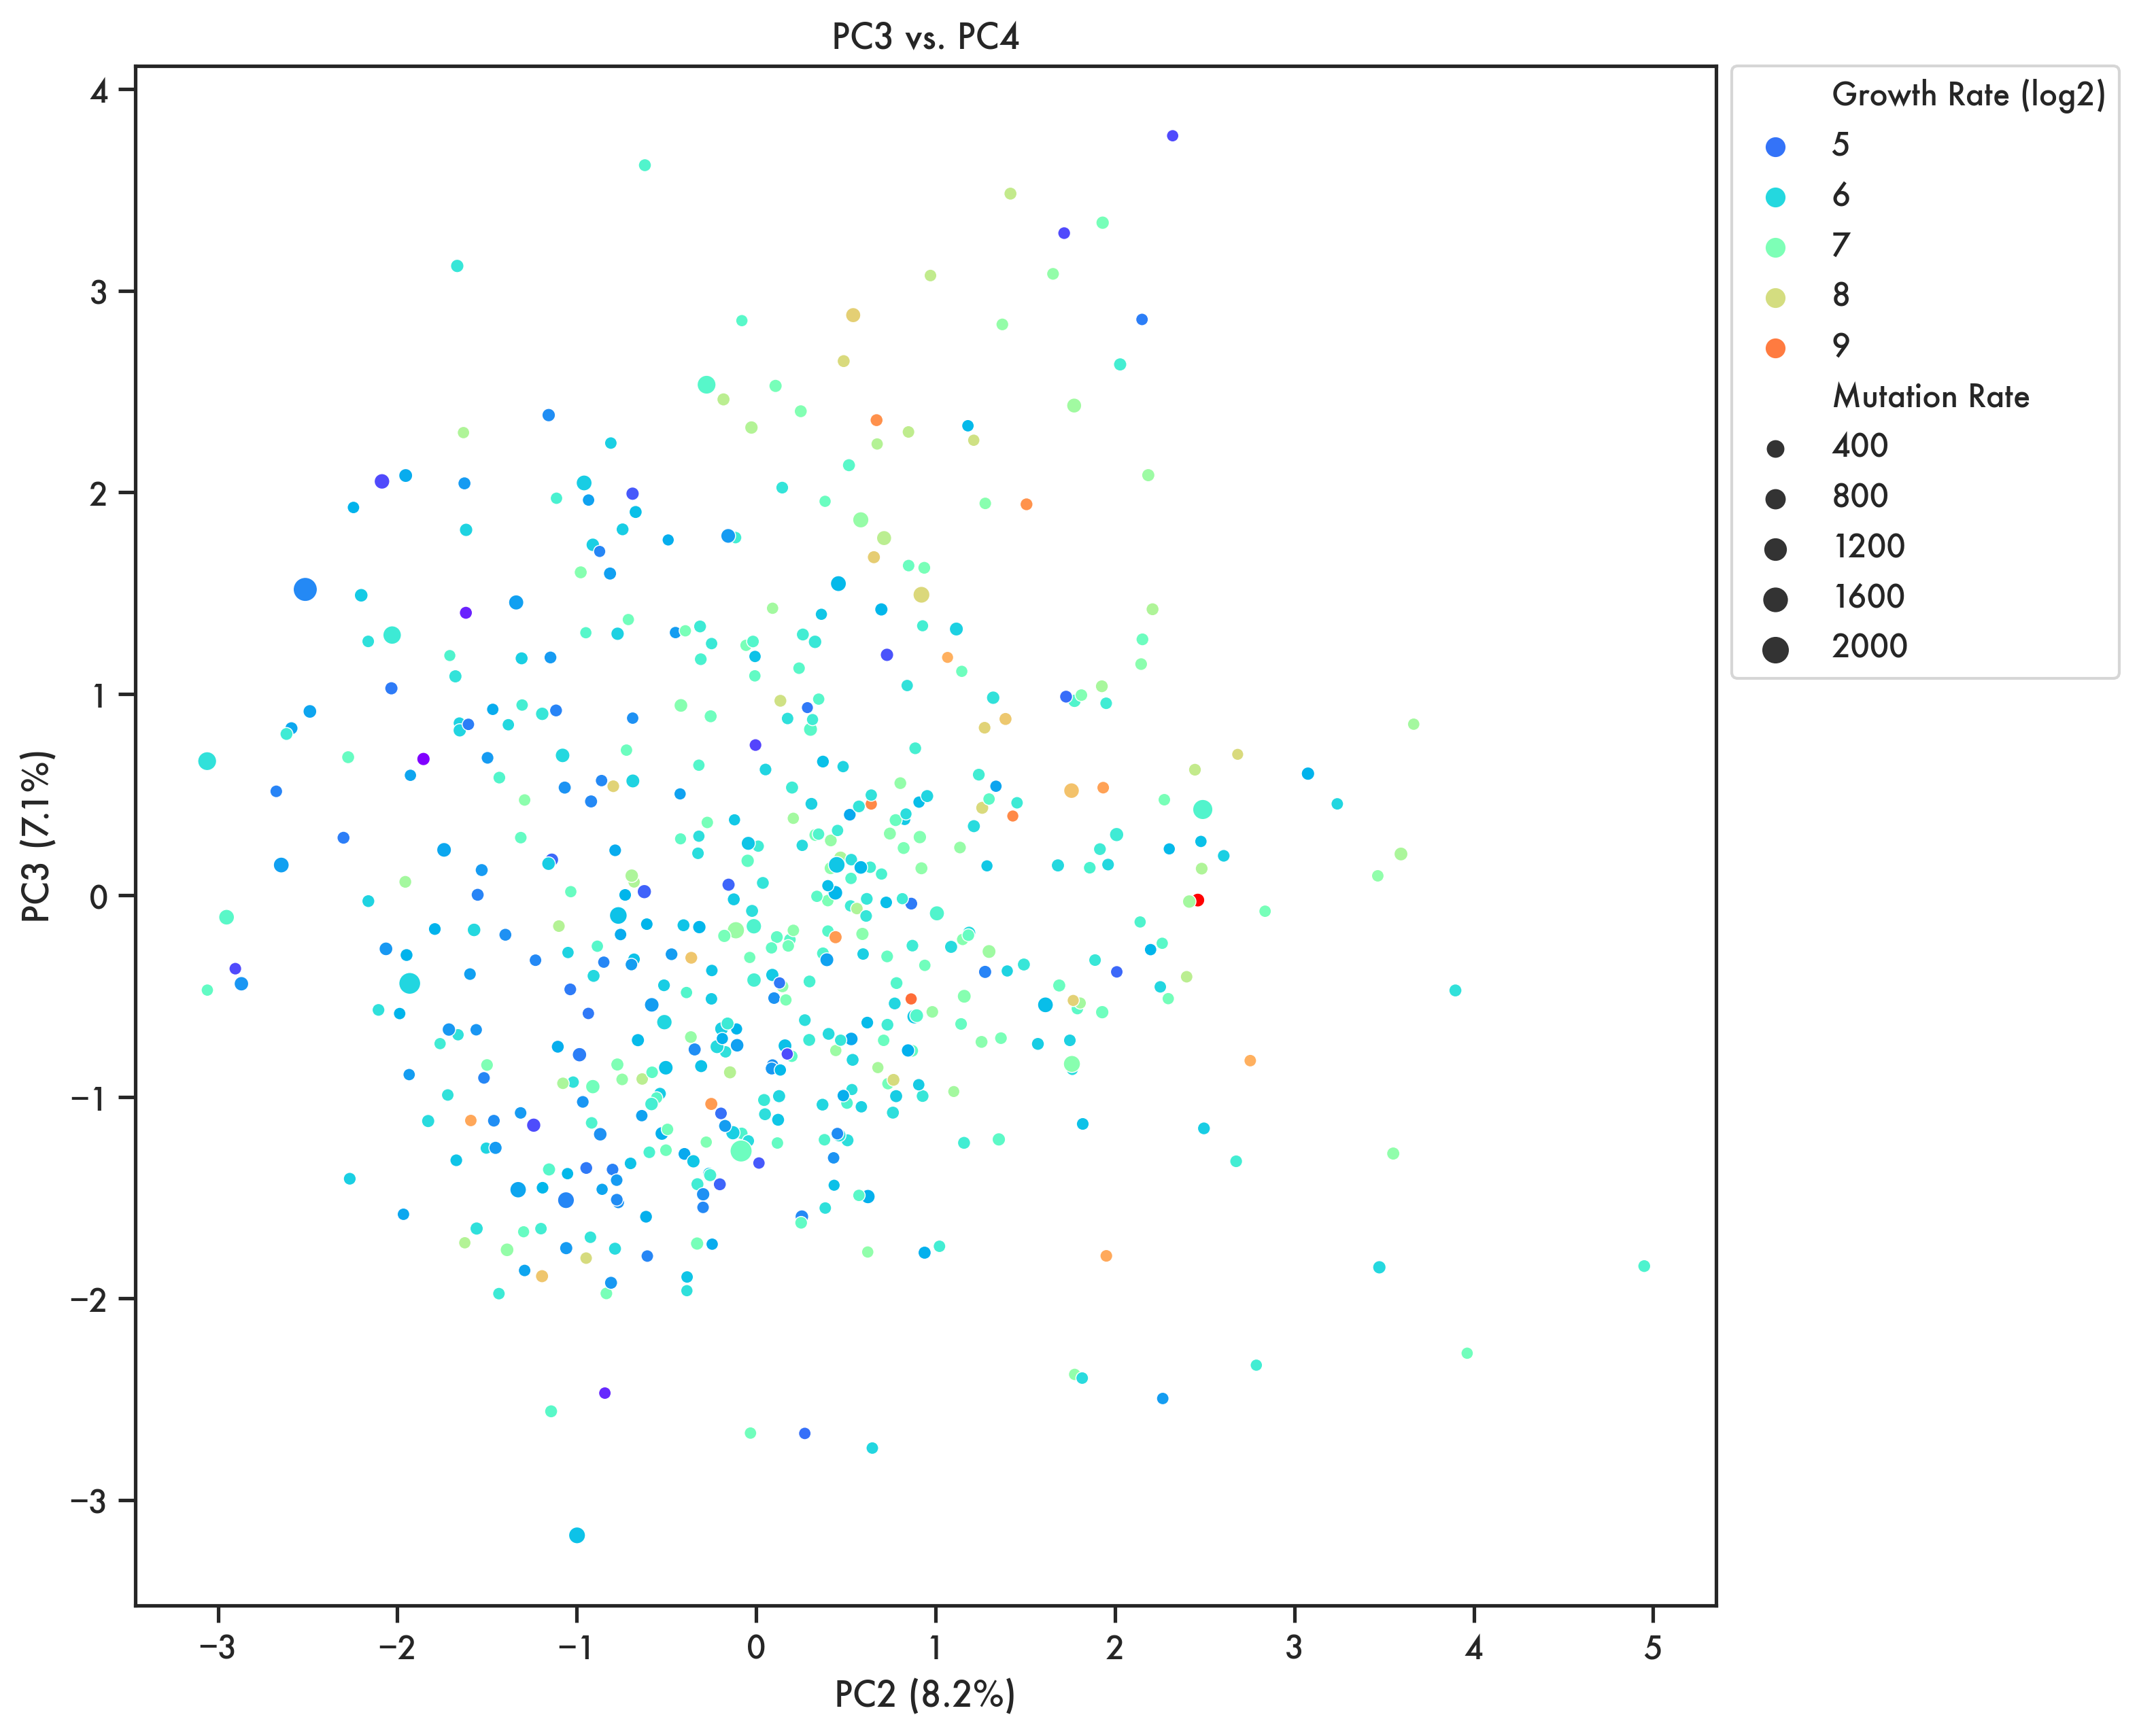

In [17]:
# log2 reasoning using formula of doubling time
sns.set_theme(style = "ticks", rc={'figure.figsize':(10,10),"figure.dpi":300, 'savefig.dpi':300,"font.family":"Futura"})
fig,axpca = plt.subplots()
metabolism_data_sub = metabolism_data.dropna(subset = ["Doubling.Time.Calculated.hrs", "mutRate"])
metabolism_data_sub.insert(0, "Doubling Time", metabolism_data_sub.pop("Doubling.Time.Calculated.hrs"))
metabolism_data_sub["Growth Rate (log2)"] = np.log2(metabolism_data_sub["Doubling Time"].astype(float))
metabolism_data_sub.insert(0, "Mutation Rate", metabolism_data_sub.pop("mutRate"))
scatter = sns.scatterplot(x = "PC2", y = "PC3", data=metabolism_data_sub,hue = metabolism_data_sub["Growth Rate (log2)"],size =metabolism_data_sub["Mutation Rate"].astype(float), palette = "rainbow")
axpca.set(xlabel='PC2 ({}%)'.format(round(explained_variance[1]*100, 1)), ylabel='PC3 ({}%)'.format(round(explained_variance[2]*100, 1)),title = "PC3 vs. PC4")
sns.move_legend(axpca,"upper left", bbox_to_anchor=(1, 1.01))

In [18]:
metabolism_data_sub = metabolism_data.dropna(subset = ["Doubling.Time.Calculated.hrs"])
metabolism_data_sub = metabolism_data_sub.dropna(subset = ["mutRate"])

Calculate matrix of R and correlation of media components and PC's 4/5

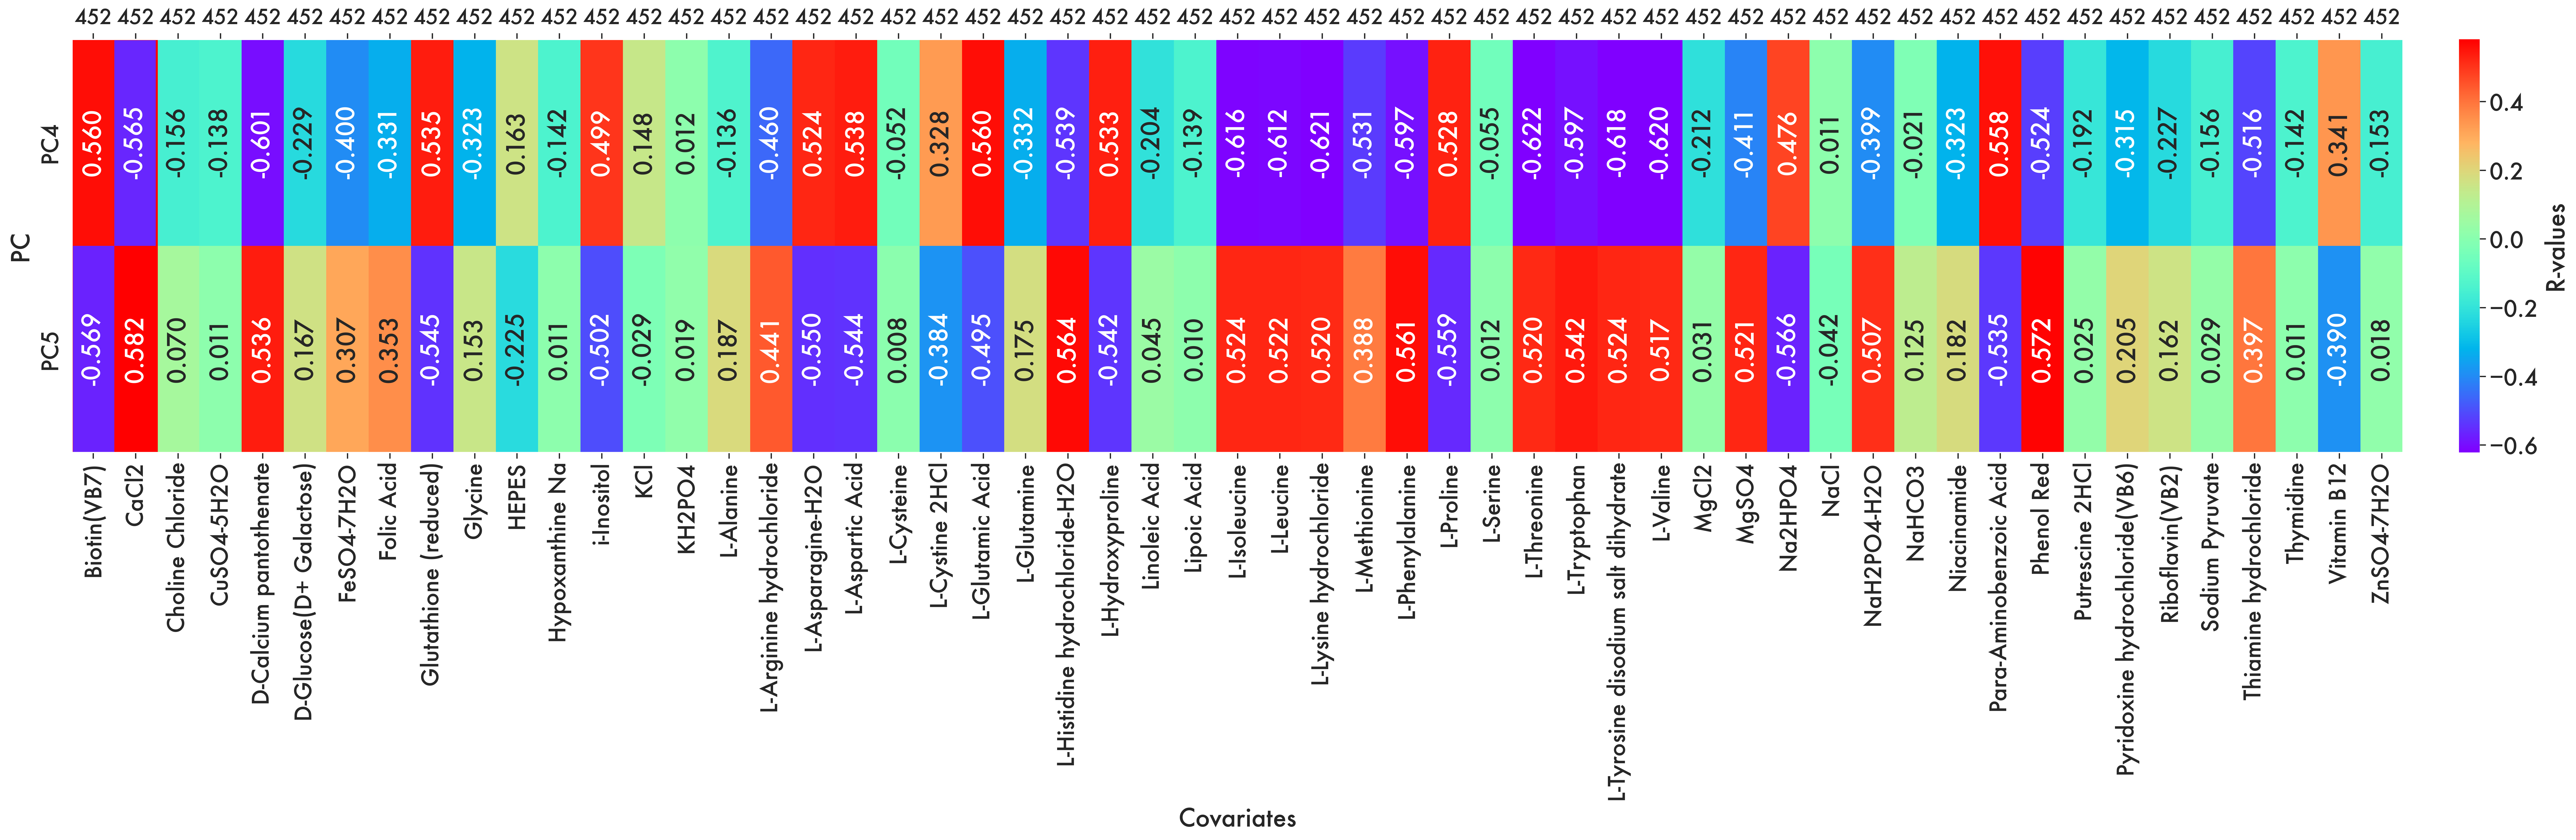

In [74]:
from matplotlib.patches import Rectangle
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(40,12),"figure.dpi":300, 'savefig.dpi':300, "font.family":"Futura"})
meta_variables = ["mutRate", "Doubling.Time.Calculated.hrs"] + list(meta_data.iloc[:,-55:].columns)
number_of_pc = 5
X_2D = X_2D[:,:5]
R_df = pd.DataFrame()
cell_lines_used = []  
for variable in meta_variables:
    meta_data_analysis = meta_data.dropna(axis =0, subset = [variable])
    cell_lines_used.append(len(meta_data_analysis))
    list_of_R = []
    pc_sub = pd.DataFrame(data=  X_2D, index = metabolism_data.index ).loc[meta_data_analysis.index]
    for PC in pc_sub.columns:
        rho, p = spearmanr(pc_sub[PC], [float(x) for x in meta_data_analysis[variable]])
        list_of_R.append(rho)
    R_df[variable] = list_of_R

R_df = R_df.transpose()
R_df.columns  = ["PC" + str(x+1) for x in range((X_2D.shape[1]))]
R_df = R_df.transpose()
R_df = R_df.loc[["PC4", "PC5"]]
cell_lines_used = cell_lines_used[2:]
sns.set_theme(rc={"font.family":"Futura"}, font_scale=2)

g = sns.heatmap(R_df, cmap = "rainbow",fmt='.3f', annot = True, annot_kws = {"rotation":90},cbar_kws={'label': 'R-values', "location":"right", "pad":.02} )
g.set(ylabel = "PC", xlabel = "Covariates")
ax = g
plt.rcParams["font.family"] = "Futura"


ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks())
ax2.set_xticklabels(cell_lines_used, fontsize=20)
ax2.tick_params(top=True, direction = "out", right = False, left = False)
ax.tick_params(top=True, direction = "out", right = False, left = False)
ax2.grid(False)


ax.add_patch(Rectangle((0, 0), 2, 5, fill=False, edgecolor='red', lw=2))
plt.tight_layout()
plt.show()



p_df = pd.DataFrame()
for variable in meta_variables:
    meta_data_analysis = meta_data.dropna(axis = 0, subset = [variable])
    list_of_p = []
    pc_sub = pd.DataFrame(data= X_2D, index = metabolism_data.index ).loc[meta_data_analysis.index]
    for PC in pc_sub.columns:
        rho, p = spearmanr(pc_sub[PC], [float(x) for x in meta_data_analysis[variable]])
        list_of_p.append(p)
    p_df[variable] = list_of_p
p_df = p_df.transpose()
p_df.columns = ["PC" + str(x+1) for x in range((X_2D.shape[1]))]

Heatmap of p-values

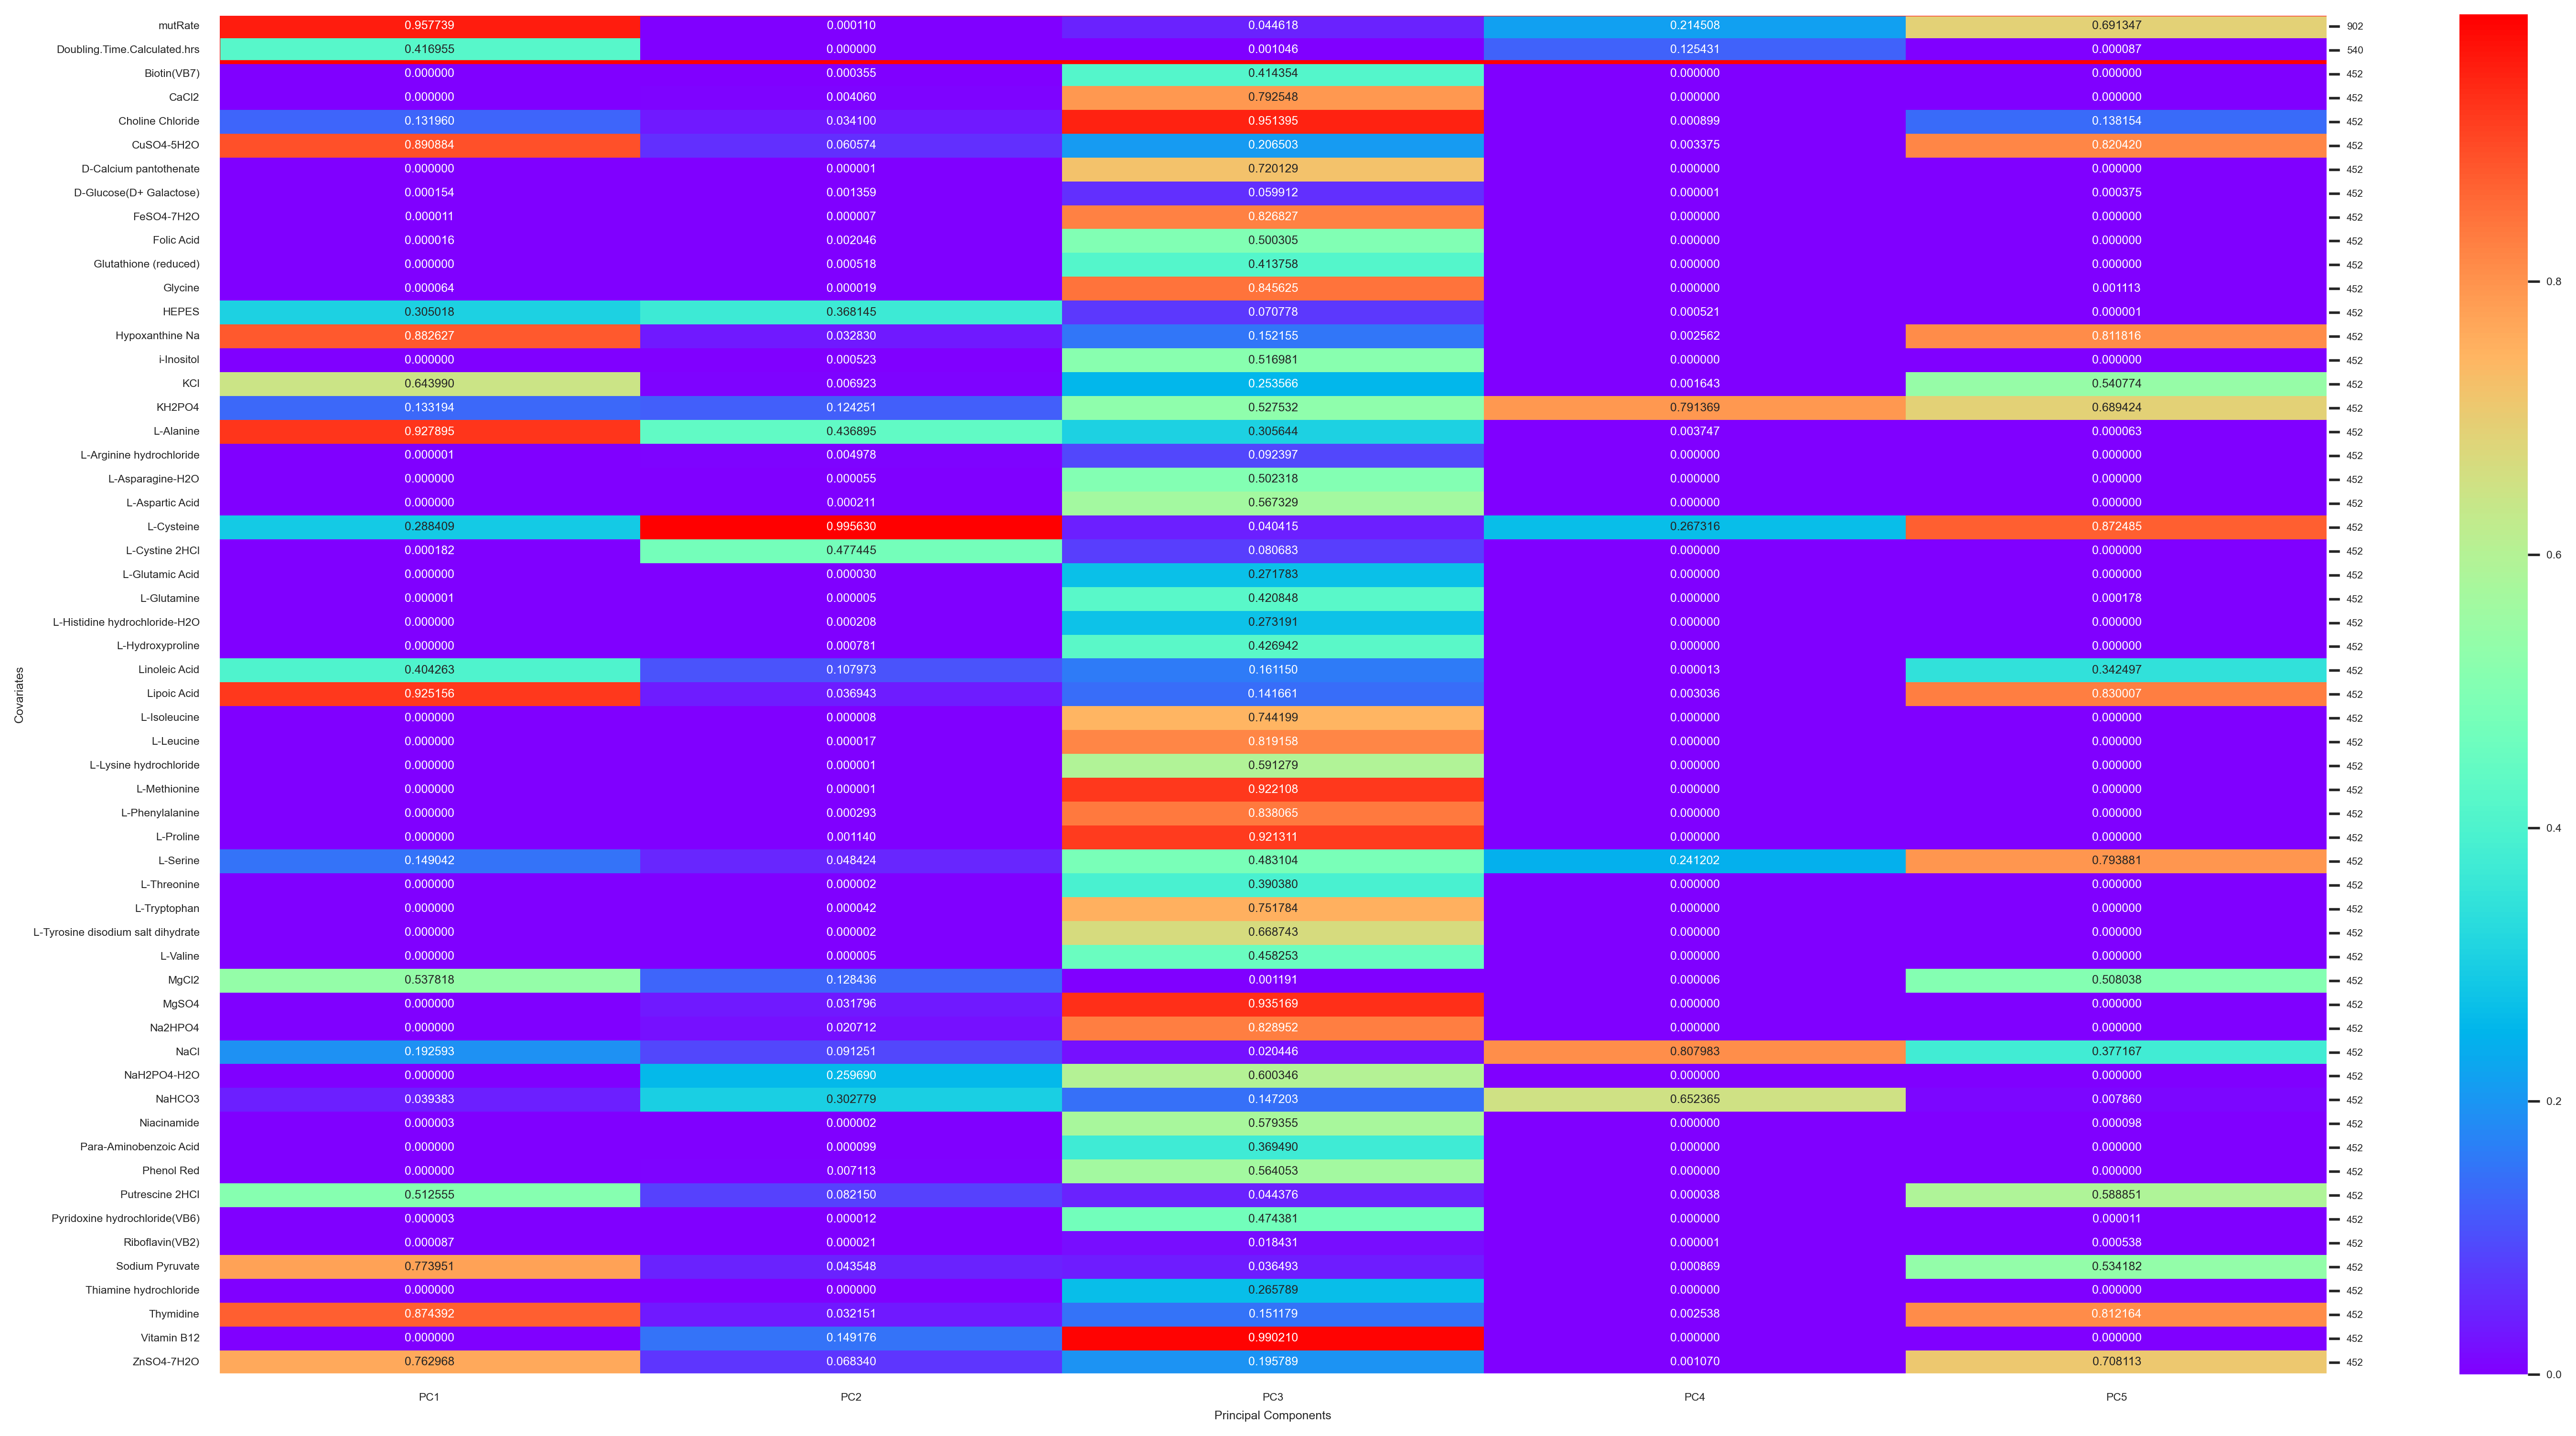

In [21]:
sns.set(font_scale=.5)
g = sns.heatmap(p_df, cmap = "rainbow",fmt = "f", annot = True)
g.set(ylabel = "Covariates", xlabel = "Principal Components")
from matplotlib.patches import Rectangle
ax = g
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(ax.get_yticks())
ax2.set_yticklabels(cell_lines_used, fontsize=5)
ax2.tick_params(top=False, direction = "out", right = True, left = False)
ax.tick_params(top=False, direction = "out", right = True, left = False)
ax2.grid(False)

ax.add_patch(Rectangle((0, 0), 10, 2, fill=False, edgecolor='red', lw=2))
plt.tight_layout()
plt.show()
